In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv

# Gene Expression model

A gene can either be on or off, in the on state a molecule M can be created, M degrades regardless of the gene state:

$ G_{off} \underset{k_{off}}{\stackrel{k_{on}}{\rightleftharpoons}} G_{on} $

$ G_{on} \stackrel{k_{tx}}\longrightarrow G_{on} + M $

$ M \stackrel{k_{deg}}\longrightarrow \varnothing $

# Bursty Gene Expression model

In the limit that $ k_{tx} $ becomes large (and $ k_{on} << k_{off} $ ??) this model can be approximated by bursting behaviour, where a random (geometrically distributed) number of molecules are created at a certain rate, and degrade at another rate:

$ \varnothing \stackrel{k_{0}}\longrightarrow m X \text{ , } m \sim Geom(b) $

$ X \stackrel{k_{1}}\longrightarrow \varnothing $

We can equivalently describe this as a process with reactions for each burst size:

$ \varnothing \stackrel{k_{0} \pi_{1}}\longrightarrow X \quad \varnothing \stackrel{k_{0} \pi_{2}}\longrightarrow 2X \quad \cdots \quad
\varnothing \stackrel{k_{0} \pi_{3m}}\longrightarrow mX \quad \cdots \quad \text{ , where } \pi_{x} = P(m = x) \text{ , } m \sim Geom(b) $

$ X \stackrel{k_{1}}\longrightarrow \varnothing $





# Simulation

First simulate paths of the model, so long term averages to approximate the stationary distribution can be found

Use Gillespie to simulate exponential holding times, and transition probabilities given reaction rates:

In [2]:
def sample_path_bursty(initial_state, params, tmax, plot=False):
    """
    Simulate a sample path of bursty gene expression

    Inputs:
    initial state: positive integer initial value of path
    params: [k0, k1, b] positive values of reaction rates and geometric dist parameter
    tmax: length of sample path
    plot: whether to plot the sample path

    Outputs:
    path: list of visited states
    jump_times: list of state transition times
    """

    # initialise time and state (also store jump times)
    t = 0
    path = [initial_state]
    jump_times = [0]
    k0, k1, b = params[0], params[1], params[2]

    # simulate until stopping time
    while t < tmax:
        # simulate holding time of current state (x)
        x = path[-1]

        # define rates
        # degradation: q(x,x-1) = k1x
        q_deg = k1 * x
        # -q(x,x): holding rate = sum q(x,y) over y
        q_hold = k1 * x + k0
        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        # P(x -> y) = q_xy / q_hold

        # simulate degradation or burst
        jump = np.random.choice([0,1],p=[q_deg / q_hold, 1 - q_deg / q_hold])
        # degradation
        if jump == 0:
            path.append(x - 1)
        # bursting
        else:
            # simulate m = geom(b)
            m = np.random.geometric(b)
            path.append(x + m)

    if plot:
        # plot path against jump times
        plt.plot(jump_times, path)
        plt.xlabel("Time")
        plt.ylabel("Number of molecules")

    return path, jump_times

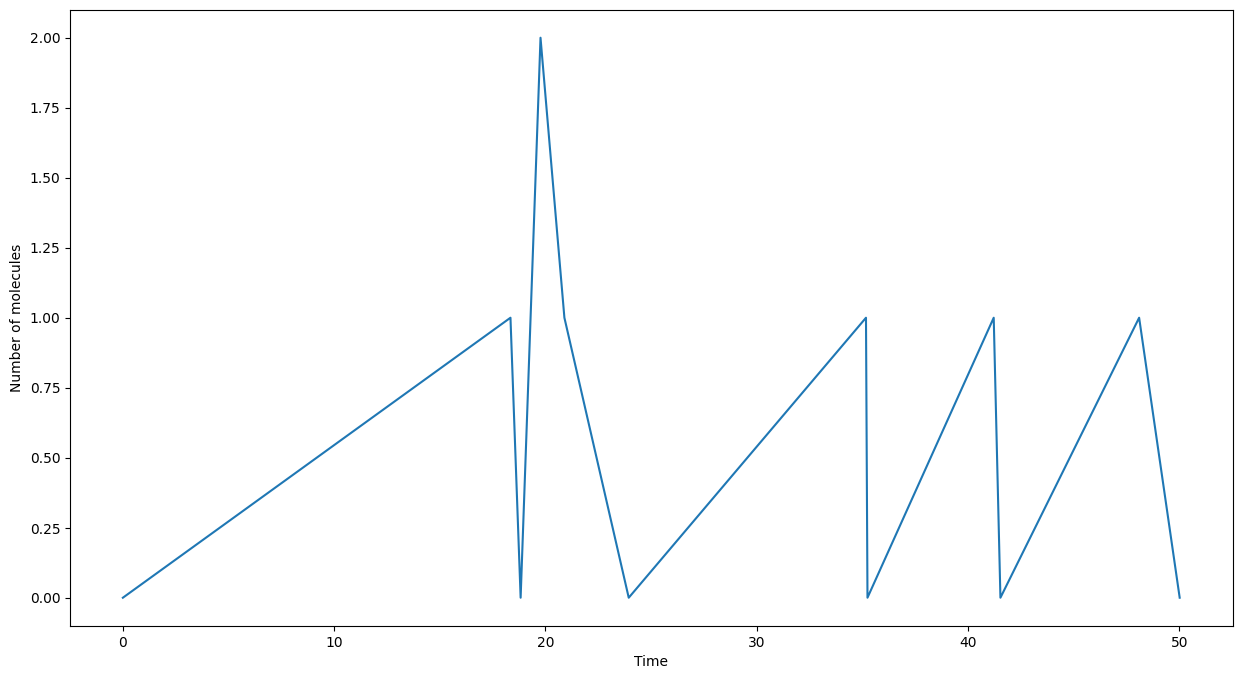

In [3]:
# test
plt.figure(figsize=(15, 8))
path, jumps = sample_path_bursty(0, [0.2, 0.8, 0.9], 50, plot=True)

# Bootstrapping

Method:
- simulate sample path up to time t (sufficiently large for stationarity behaviour)
- record final state (a sample from the stationary distribution)
- repeat for n samples

bootstrapping:
- sample with replacement to obtain N bootstrap samples from the n values
- calculate the proportion of states x for each sample (estimate of p(x))
- find Confidence Intervals for each estimate using quantiles of bootstrap estimates

In [3]:
def bootstrap(x_list, initial_state, params, tmax, n, N, plot=False, printing=False):
    """
    Use sample paths and bootstrapping to find confidence intervals of
    stationary distribution values.

    Inputs:
    x_list: states to calculate stationary estimates for
    initial state: initial value of all sample paths
    params: [k0, k1, b]
    tmax: length of simulation
    n: number of sample paths
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of states in x_list
    """

    # simulate n sample paths
    states = []
    for i in range(n):
        path, jumps = sample_path_bursty(initial_state, params, tmax, plot=plot)
        states.append(path[-2]) # last state before tmax
    plt.show()

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return intervals

### Testing

See that good bounds are produced

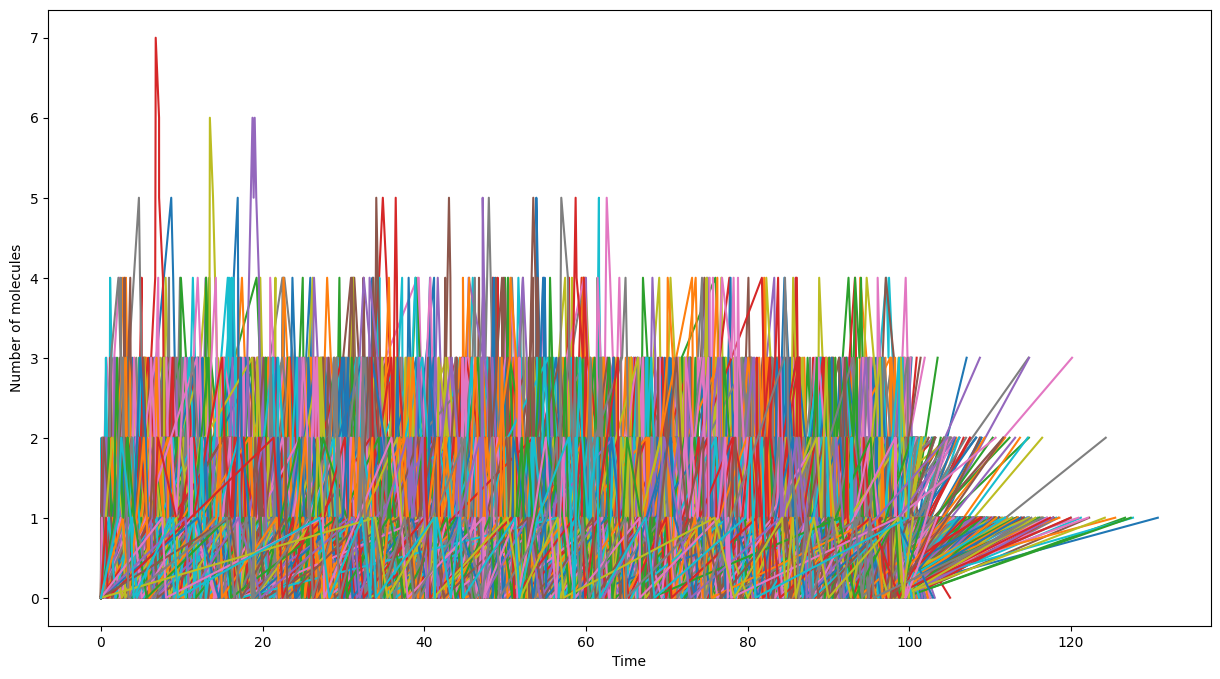

95% CI for p(0) is: (0.798, 0.845)


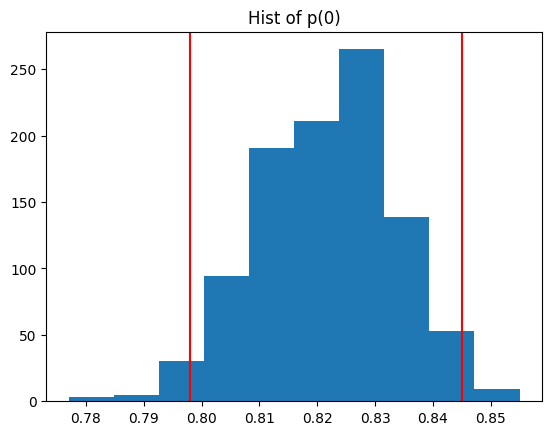

95% CI for p(1) is: (0.13, 0.174)


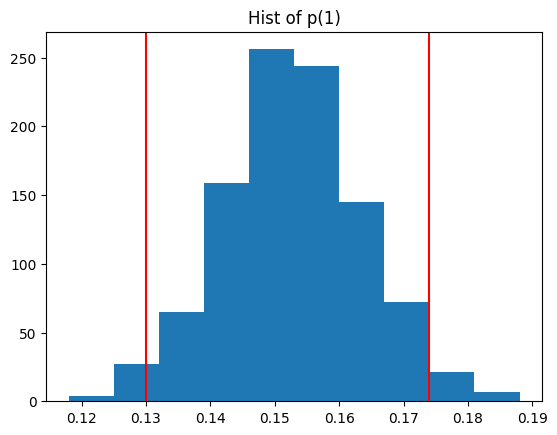

95% CI for p(2) is: (0.014, 0.034)


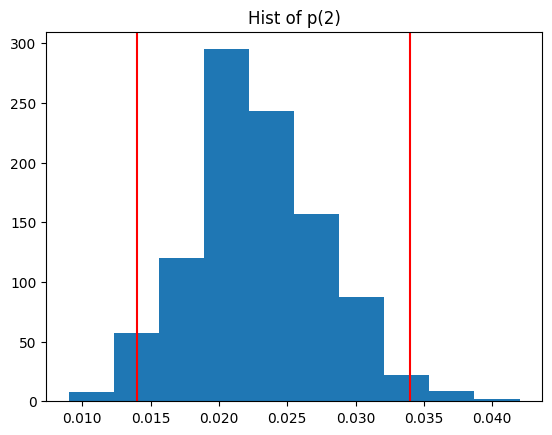

95% CI for p(3) is: (0.0, 0.007)


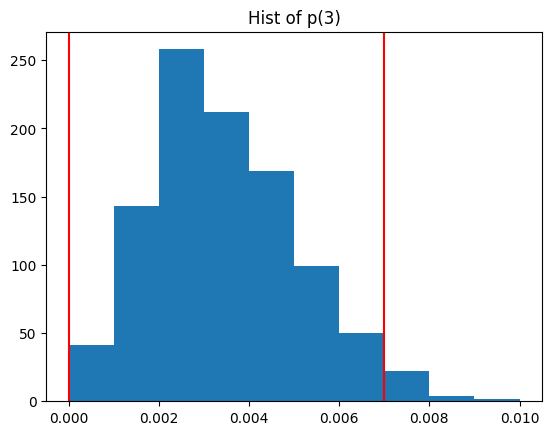

95% CI for p(4) is: (0.0, 0.0)


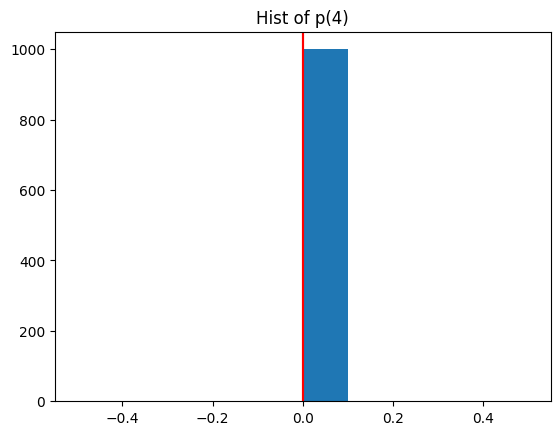

In [5]:
# test
plt.figure(figsize=(15, 8))
intervals = bootstrap([0,1,2,3,4],0,[0.2,1,0.9],100,1000,1000,plot=True,printing=True)

# Linear Programming

Formulate the constraints on parameters of the markov chain, linearising using cross term substitutions when appropriate

In [6]:
# number of rows of Q (/ number of equations used)
N = 3
# maximum burst size to consider
M = 4

# create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
# Q1: degradation
Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
# Q00, Q01, ... : bursting
Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
def Q0(m):
    """m = {1, 2, ...}"""
    return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

# bounds from CI
pl = [intr[0] for intr in intervals]
pu = [intr[1] for intr in intervals]

# define bounds: truncate to N + 1 values as using up to Nth equation
pl = np.array(pl)[:N + 1]
pu = np.array(pu)[:N + 1]

# Construct the problem

# Variables
k0 = cv.Variable(1)
#k1 = cv.Variable(1)
k1 = 1
mu1 = cv.Variable(1)
mu2 = cv.Variable(1)
mu3 = cv.Variable(1)
# look into vector of mu_m's
z0 = cv.Variable(N + 1)
z1 = cv.Variable(N + 1)
y1 = cv.Variable(N + 1)
y2 = cv.Variable(N + 1)
y3 = cv.Variable(N + 1)
# look into M x N + 1 matrix of y vectors
objective_max = cv.Maximize(mu1)
objective_min = cv.Minimize(mu1)

# constraints
constraints = [
    Q1 @ z1 + Q00 @ z0 + Q0(1) @ y1 + Q0(2) @ y2 + Q0(3) @ y3 == 0,
    k0 >= 0, k1 >= 0, mu1 >= 0, mu2 >= 0, mu3 >= 0, z0 >= 0, z1 >= 0, y1 >= 0, y2 >= 0, y3 >= 0,
    k0 * pl <= z0, z0 <= k0 * pu,
    k1 * pl <= z1, z1 <= k1 * pu,
    mu1 * pl <= y1, y1 <= mu1 * pu,
    mu2 * pl <= y2, y2 <= mu2 * pu,
    mu3 * pl <= y3, y3 <= mu3 * pu,
    y1 + y2 + y3 <= z0,
    mu1 + mu2 + mu3 <= k0,
    # missing distributional bounds (appears not to make any difference)
    sum([z0[x] for x in range(N + 1)]) <= k0,
    sum([z1[x] for x in range(N + 1)]) <= k1,
    sum([y1[x] for x in range(N + 1)]) <= mu1,
    sum([y2[x] for x in range(N + 1)]) <= mu2,
    sum([y3[x] for x in range(N + 1)]) <= mu3,

]
prob_max = cv.Problem(objective_max, constraints)
prob_min = cv.Problem(objective_min, constraints)   

# Print result.
result_max = prob_max.solve()
print(prob_max.status)
print("\nThe upper bound is")#, prob_max.value)
print(f"k0 {k0.value}")
print(f"k1 {k1}")
print(f"mu1 {mu1.value}")
print(f"mu2 {mu2.value}\n")
result_min = prob_min.solve()
print(prob_min.status)
print("\nThe lower bound is")#, prob_min.value)
print(f"k0 {k0.value}")
print(f"k1 {k1}")
print(f"mu1 {mu1.value}")
print(f"mu2 {mu2.value}")

optimal

The upper bound is
k0 [0.21804511]
k1 1
mu1 [0.21804511]
mu2 [-3.41800398e-13]

optimal

The lower bound is
k0 [0.15384615]
k1 1
mu1 [0.09704142]
mu2 [0.04586477]


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


$ \mu_1 = k_0 \pi_1 = 0.18 $ so bounds of [0.11, 0.23] are very good, espically given small number of equations used. $ \mu_2 $ also has good bounds. 

This is with only specififying $ k_1 = 1 $ and leaving $ k_0 $ and birth distribution unkown.

# LP pipeline

Formalise to take inputs of number of equations to use, confidence intervals (data), parameters (specified values or unkown) and solve LP's to min and max each unkown parameter, outputting solution intervals.

In [4]:
def bursty_LP(N, intervals, k0=None, k1=None, M=None):
    """
    Solve bursty LP system to get interval bounds on parameters.

    Inputs:
    N: number of rows of Q / number of equations used
    M: maximum burst size to consider (>= 1)
    intervals: confidence intervals for at least N + 1 states

    Outputs:
    solutions: dict with keys variables, values their solution intervals
    """
    # if max burst not specified: set to the largest burst that appears in Qp = 0 constraint
    if not M:
        M = N - 1

    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # bounds from CI
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds: truncate to N + 1 values as using up to Nth equation
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]

    # Construct the problem

    # Variables: specify k1 or k0 manually
    if not k0:
        k0 = cv.Variable()
    if not k1:
        k1 = cv.Variable(1)
    mu = cv.Variable(M)
    z0 = cv.Variable(N + 1)
    z1 = cv.Variable(N + 1)
    y = cv.Variable((N + 1, M))

    # constraints
    constraints = [
        Q1 @ z1 + Q00 @ z0 + sum([Q0(m + 1) @ y[:, m] for m in range(0, M)]) == 0,
        k0 >= 0, k1 >= 0, mu >= 0, z0 >= 0, z1 >= 0, y >= 0,
        k0 * pl <= z0, z0 <= k0 * pu,
        k1 * pl <= z1, z1 <= k1 * pu,
        sum([y[:, m] for m in range(0, M)]) <= z0,
        sum([mu[m] for m in range(0, M)]) <= k0,
        # dist. const.
        sum([z0[x] for x in range(N + 1)]) <= k0,
        sum([z1[x] for x in range(N + 1)]) <= k1
    ]
    for m in range(0, M):
        constraints +=  [
            mu[m] * pl <= y[:, m], y[:, m] <= mu[m] * pu,
            # dist. const.
            sum([y[x, m] for x in range(N + 1)]) <= mu[m]
        ]

    # solution interval dict
    solutions = {}

    # solver function
    def solver(dict_name, var, solutions):
        # create inteval
        solutions[dict_name] = []
        # min and max objectives
        objective_min = cv.Minimize(var)
        objective_max = cv.Maximize(var)
        # min and max problems
        prob_min = cv.Problem(objective_min, constraints)
        prob_max = cv.Problem(objective_max, constraints)   
        # solve min: add to solution
        result_min = prob_min.solve()
        try:
            solutions[dict_name].append(var.value.item())
        except:
            solutions[dict_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve()
        try:
            solutions[dict_name].append(var.value.item())
        except:
            solutions[dict_name].append(None)
        # add statuses
        solutions[dict_name].append(prob_min.status)
        solutions[dict_name].append(prob_max.status)

    # solve for k0
    if type(k0) == int:
        solutions['k0'] = k0
    else:
        solver('k0', k0, solutions)

    # solve for k1
    if type(k1) == int:
        solutions['k1'] = k1
    else:
        solver('k1', k1, solutions)

    # solve for mu_1, mu_2, ..., mu_M
    for m in range(0, M):
        solver(f'mu_{m + 1}', mu[m], solutions)

    return solutions

### Testing

Using intervals simulated earlier with parameters: 

$ k_0 = 0.2 , k_1 = 1 , b = 0.9 $

Giving:

$ \mu_1 = 0.18 , \mu_2 = 0.018, \mu_3 = 0.0018 $

Using only a few equations (2 to 4) with known $ k_1 = 1 $ good bounds can be obtained:

In [8]:
solutions = bursty_LP(3, intervals, k1=1)

In [9]:
solutions

{'k0': [0.1538461538447949, 0.21804511278258404, 'optimal', 'optimal'],
 'k1': 1,
 'mu_1': [0.09704142011471807, 0.2180451127834651, 'optimal', 'optimal'],
 'mu_2': [-1.1295664726651426e-13, 0.059610240735139035, 'optimal', 'optimal']}

# Estimating distributions

So far we have simulated a geometric distribution of burst size rates, but the distribution of births could be any distribution. Given data, simulated from a model with a given distribution, we can solve LP's to find confidence intervals for the distribution. Plotting these intervals against a hypothesised distribution we can see if it is valid.

### fixing parameters

Fixing $ k_0 = 1 $ means that $ \mu_m = \pi_m $, so the LP solution directly gives the birth distribution (or a known multiple: The probabilities can become very small so it may be useful to scale them by choosing a larger value?)

95% CI for p(0) is: (0.781, 0.832)
95% CI for p(1) is: (0.143, 0.18902499999999997)
95% CI for p(2) is: (0.015, 0.033)
95% CI for p(3) is: (0.0, 0.006)
95% CI for p(4) is: (0.0, 0.003)
95% CI for p(5) is: (0.0, 0.0)
95% CI for p(6) is: (0.0, 0.0)
{'k0': 1, 'k1': [4.1317286073009845, 5.818181818212262, 'optimal', 'optimal'], 'mu_1': [0.6773298816555056, 1.0000000000002183, 'optimal', 'optimal'], 'mu_2': [-6.884085832351911e-13, 0.29955062625584405, 'optimal', 'optimal'], 'mu_3': [-2.787653892689156e-13, 0.09643742954456404, 'optimal', 'optimal']}


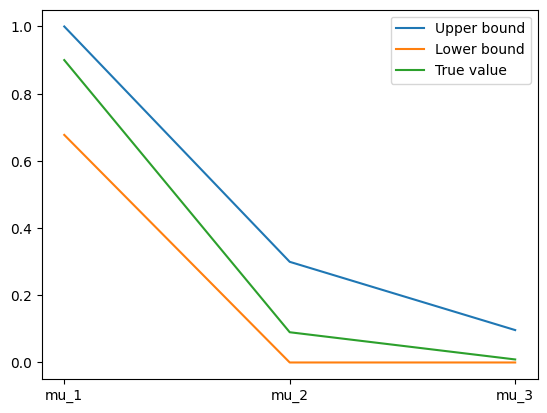

In [10]:
# simulate data from geometric distribution with b = 0.9
intervals_dist = bootstrap([x for x in range(0, 7)],0,[1,5,0.9],100,1000,1000,plot=False,printing=True)

# solve LP using data
N = 4
M = N - 1
solutions_dist = bursty_LP(N, intervals_dist, k0=1)

# extract distribution bounds
labels = [f'mu_{m}' for m in range(1, M + 1)]
lower = [solutions_dist[var][0] for var in labels]
upper = [solutions_dist[var][1] for var in labels]

# true distribution
true_dist = [0.9 * (1 - 0.9)**m for m in range(0, M)]

# plot
plt.plot(labels, upper, label = "Upper bound")
plt.plot(labels, lower, label = "Lower bound")
plt.plot(labels, true_dist, label = "True value")
plt.legend()

# print bounds
print(solutions_dist)

Note that sometimes the LP is infeasible, or adding too many equations leads to upper and lower bounds for all $ \mu_m $ becoming zero. This is due to sampling error in the stationary distribution confidence intervals leading to inconsistent data. This problem may also be amplified by the very small values that the $ \mu_m $'s take, as even small discrepancies can cause problems.

95% CI for p(0) is: (0.7926, 0.8148)
95% CI for p(1) is: (0.1584, 0.1794)
95% CI for p(2) is: (0.019, 0.0274)
95% CI for p(3) is: (0.002, 0.0054)
95% CI for p(4) is: (0.0, 0.001)
95% CI for p(5) is: (0.0, 0.0006)
95% CI for p(6) is: (0.0, 0.0)
{'k0': 1, 'k1': [4.418060200562029, 5.143939394033876, 'optimal', 'optimal'], 'mu_1': [0.8306239865485812, 1.000000000000607, 'optimal', 'optimal'], 'mu_2': [-1.448226153542889e-12, 0.15430578302769477, 'optimal', 'optimal'], 'mu_3': [-5.692974435294708e-13, 0.06748537928659816, 'optimal', 'optimal']}


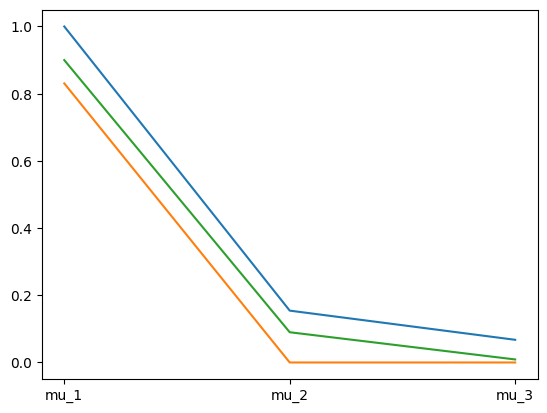

In [46]:
# simulate data from geometric distribution with b = 0.9
intervals_dist = bootstrap([x for x in range(0, 7)],0,[1,5,0.9],100,5000,5000,plot=False,printing=True)

# solve LP using data
N = 4
M = N - 1
solutions_dist = bursty_LP(N, intervals_dist, k0=1)

# extract distribution bounds
labels = [f'mu_{m}' for m in range(1, M + 1)]
lower = [solutions_dist[var][0] for var in labels]
upper = [solutions_dist[var][1] for var in labels]

# true distribution
true_dist = [0.9 * (1 - 0.9)**m for m in range(0, M)]

# plot
plt.plot(labels, upper)
plt.plot(labels, lower)
plt.plot(labels, true_dist)

# print bounds
print(solutions_dist)

Increasing the number of samples to obtain more accurate stationary bounds leads to better performance, as seen above.

Try a different set of parameters with a more spread out birth distribution:

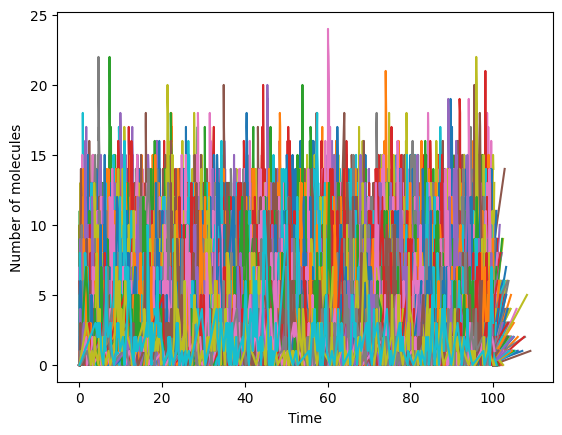

95% CI for p(0) is: (0.484, 0.5122)


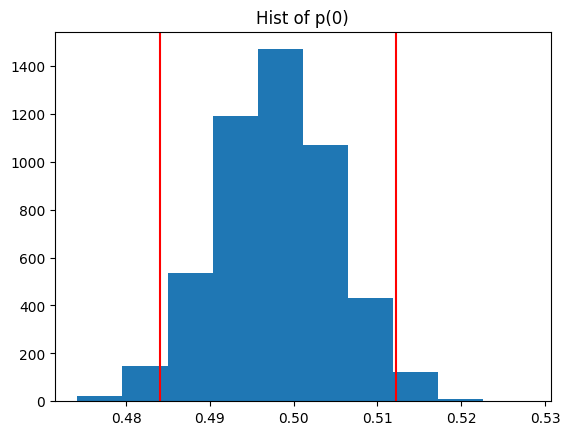

95% CI for p(1) is: (0.2372, 0.2616)


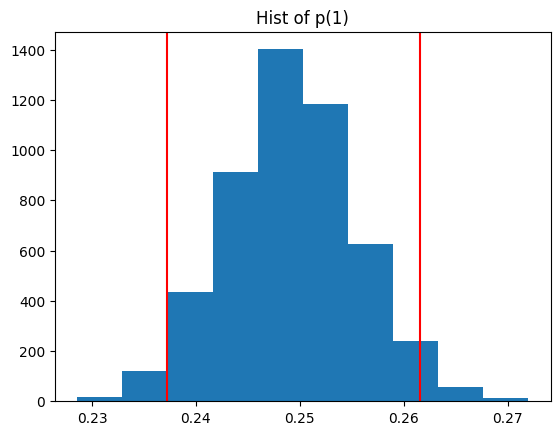

95% CI for p(2) is: (0.1136, 0.1316)


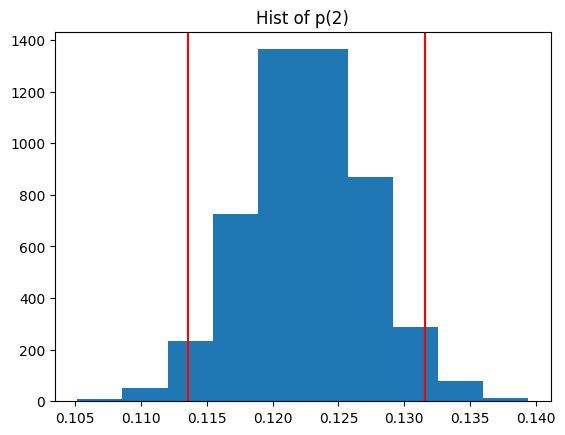

95% CI for p(3) is: (0.0594, 0.073)


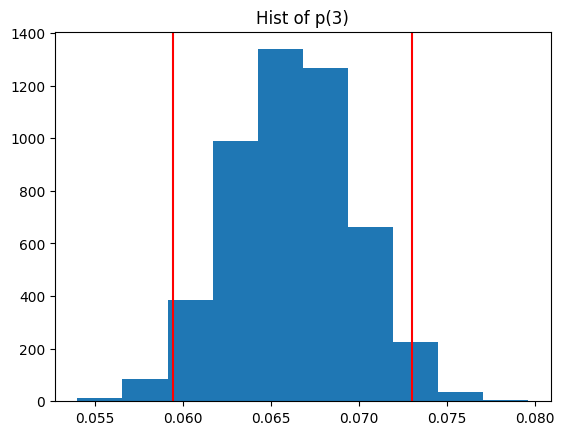

95% CI for p(4) is: (0.027, 0.037)


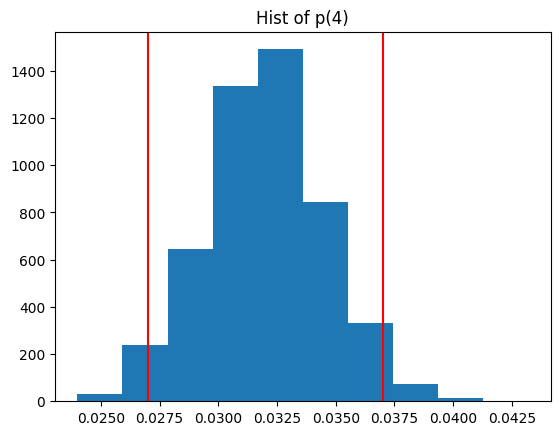

95% CI for p(5) is: (0.0132, 0.0202)


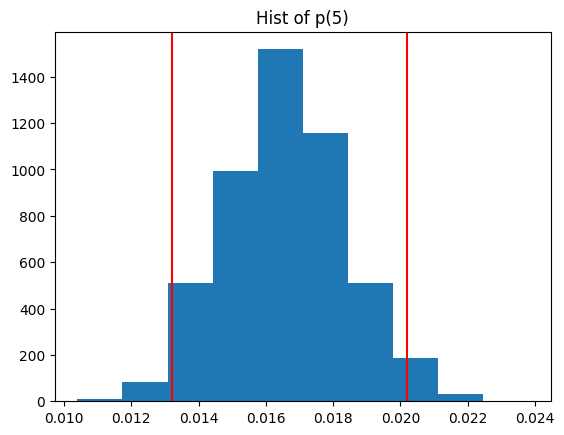

95% CI for p(6) is: (0.005, 0.0096)


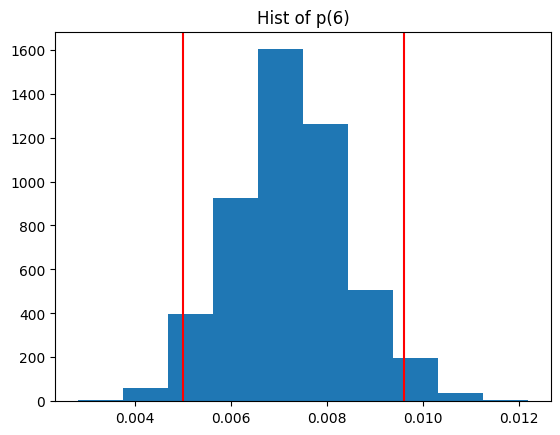

95% CI for p(7) is: (0.0024, 0.006004999999999927)


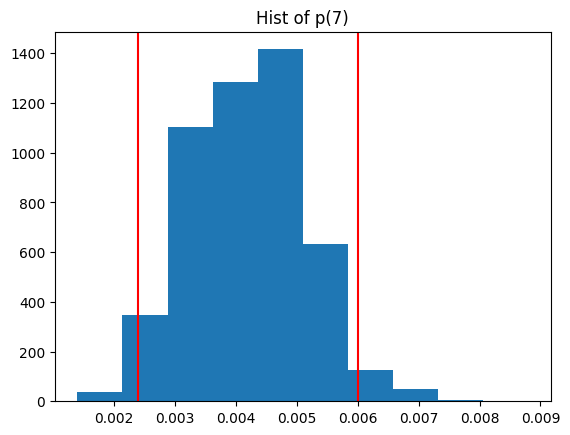

95% CI for p(8) is: (0.001, 0.0036)


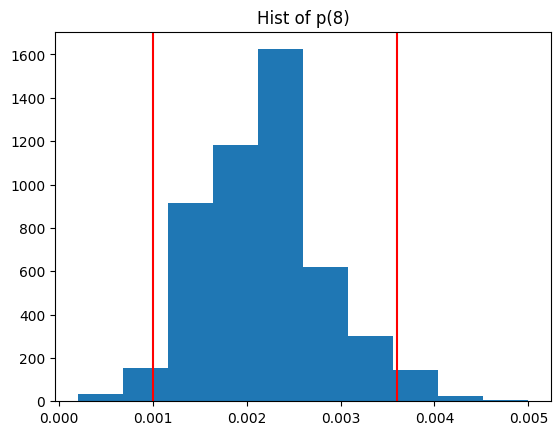

95% CI for p(9) is: (0.0002, 0.002)


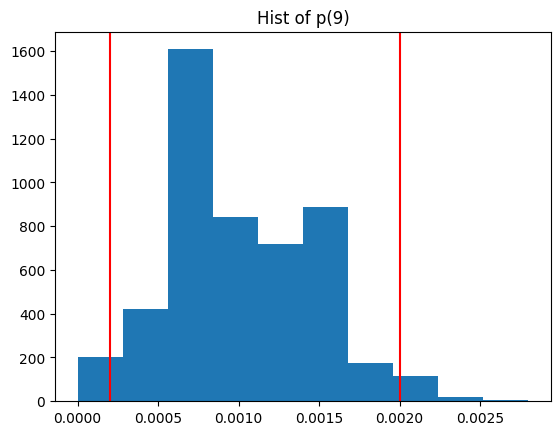

In [47]:
# simulate data from geometric distribution with b = 0.9
intervals_spread = bootstrap([x for x in range(0, 10)],0,[1,2,0.5],100,5000,5000,plot=True,printing=True)

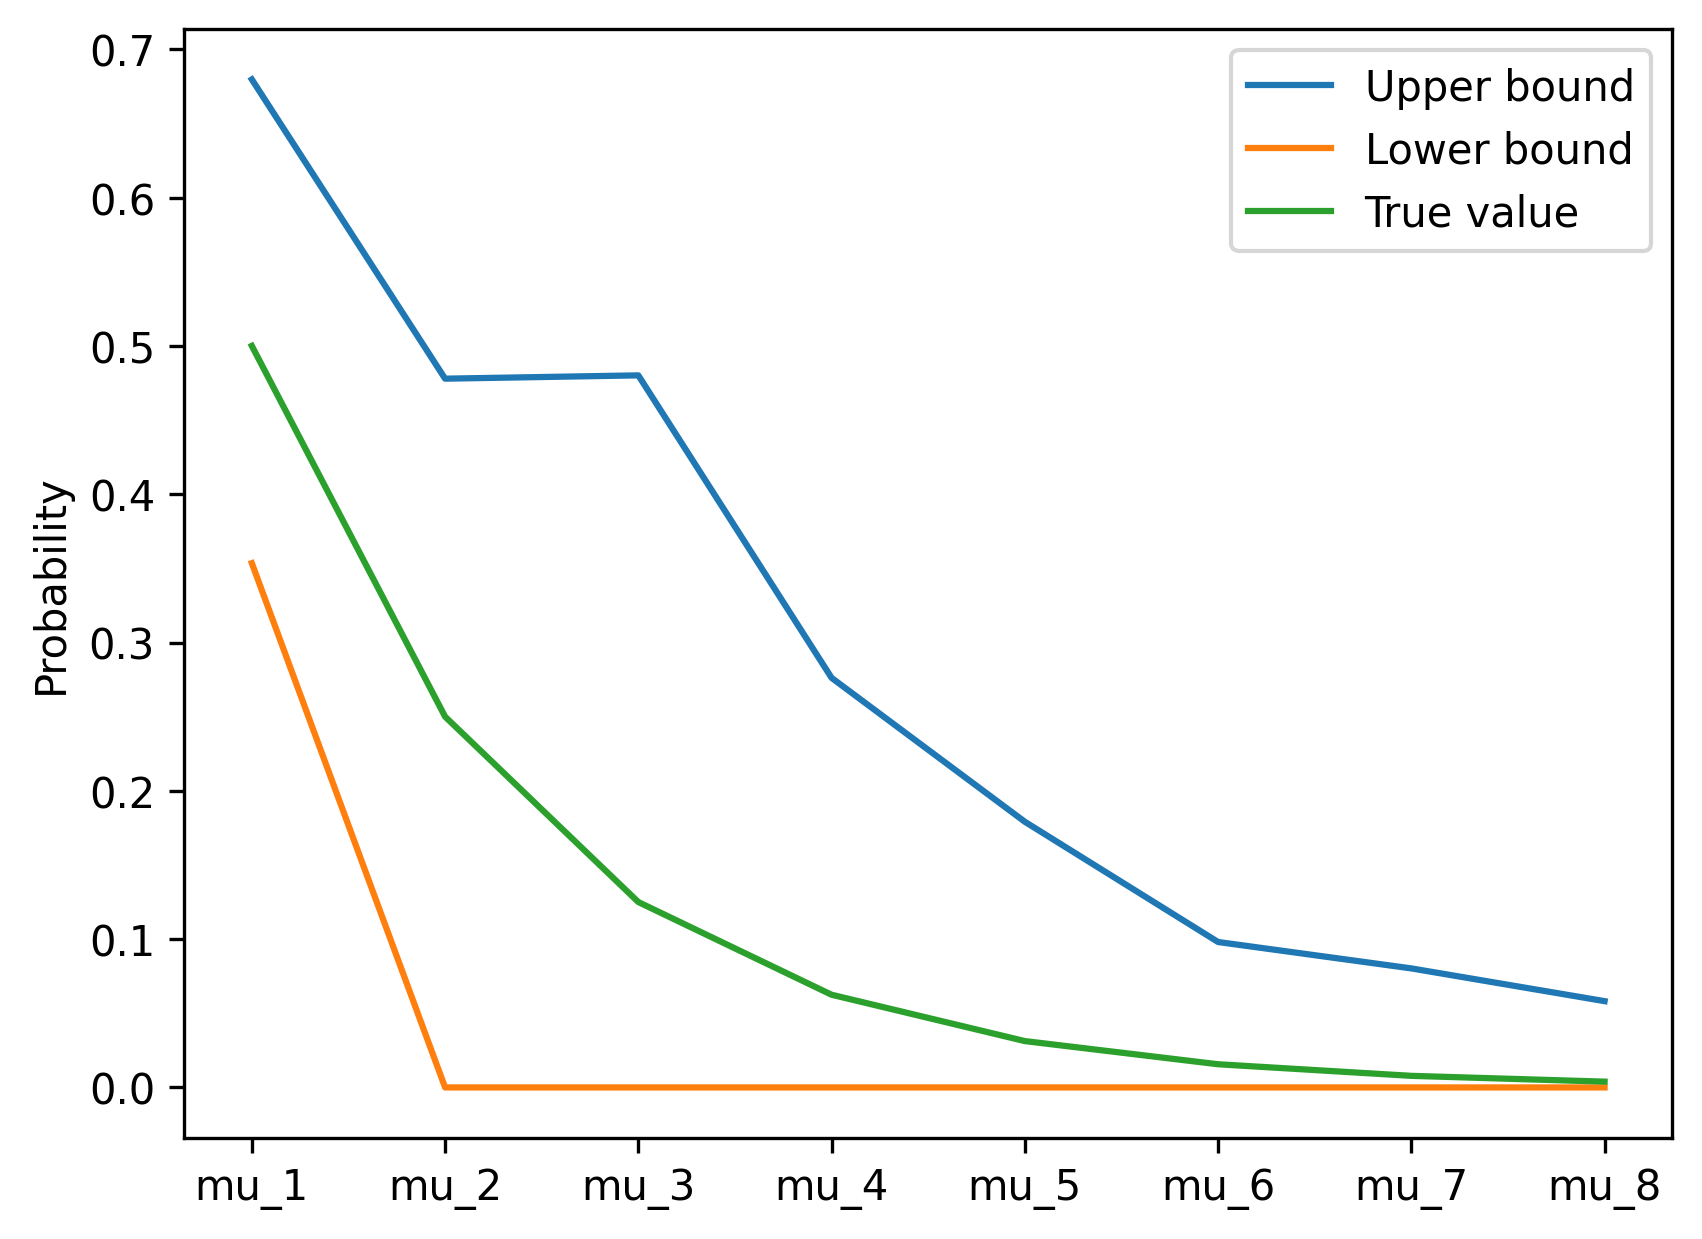

{'k0': 1, 'k1': [1.8501529051975714, 2.159359190559003, 'optimal', 'optimal'], 'mu_1': [0.3534882097712005, 0.6796560264888283, 'optimal', 'optimal'], 'mu_2': [-1.4009663225638404e-13, 0.47788869388713573, 'optimal', 'optimal'], 'mu_3': [-9.717957633845875e-14, 0.48011384243097405, 'optimal', 'optimal'], 'mu_4': [-3.248455739208581e-14, 0.2761621761005396, 'optimal', 'optimal'], 'mu_5': [-3.070142385551369e-14, 0.17914511476647307, 'optimal', 'optimal'], 'mu_6': [-3.1033509959280326e-14, 0.09805254760605778, 'optimal', 'optimal'], 'mu_7': [-2.83769954248985e-14, 0.08025990478000537, 'optimal', 'optimal'], 'mu_8': [-2.3120581603822154e-14, 0.05817949528903948, 'optimal', 'optimal']}


In [48]:
# solve LP using data
N = 9
M = N - 1
solutions_spread = bursty_LP(N, intervals_spread, k0=1)

# extract distribution bounds
labels = [f'mu_{m}' for m in range(1, M + 1)]
lower = [solutions_spread[var][0] for var in labels]
upper = [solutions_spread[var][1] for var in labels]

# true distribution
true_dist = [0.5 * (1 - 0.5)**m for m in range(0, M)]

# plot
fig = plt.figure(dpi=300)
plt.plot(labels, upper, label = "Upper bound")
plt.plot(labels, lower, label = "Lower bound")
plt.plot(labels, true_dist, label = "True value")
plt.ylabel("Probability")
plt.legend()
plt.show()

# print bounds
print(solutions_spread)

## Truncating distributions

So far we have used N equations, adding all $ \pi $'s that appear in them up to $ \pi_{N - 1} $. However, we saw that when $ \pi $'s get small trying to bound them can lead to conflicting constaints, causing infeasible problems or nonsense bounds.

We can experiment with setting a maximum burst size / truncating the birth distribution to M, effectively setting $ \pi_{m} = 0 , m > M $, by not including them as variables and not creating new $ Q_r $ matrices. Ideally we only truncate those elements that are so effectively zero.

However, this may lead to false solutions, or simply not improve anything when adding truncated equations:

In [49]:
# simulate data from geometric distribution with b = 0.9
intervals_trunc = bootstrap([x for x in range(0, 7)],0,[1,5,0.9],100,1000,1000,plot=False,printing=True)

95% CI for p(0) is: (0.781, 0.828)
95% CI for p(1) is: (0.138, 0.18202499999999996)
95% CI for p(2) is: (0.017, 0.037)
95% CI for p(3) is: (0.002, 0.011)
95% CI for p(4) is: (0.0, 0.003)
95% CI for p(5) is: (0.0, 0.003)
95% CI for p(6) is: (0.0, 0.0)


{'k0': 1, 'k1': [4.290619420153393, 6.000000000410611, 'optimal', 'optimal'], 'mu_1': [0.6041097808432843, 1.0000000000059608, 'optimal', 'optimal'], 'mu_2': [-8.43723863751805e-14, 0.3795570575979459, 'optimal', 'optimal']}


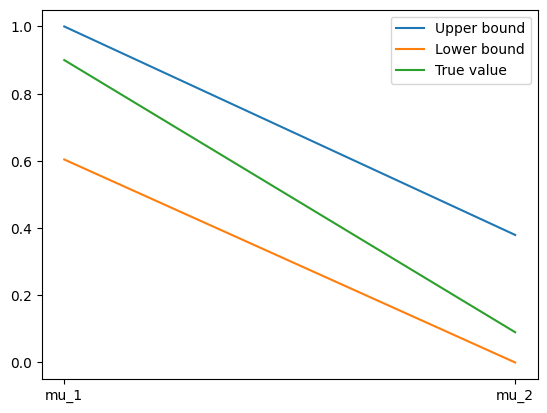

In [56]:
# solve LP using data: truncate at M (default N - 1)
N = 6
M = 2
solutions_trunc = bursty_LP(N, intervals_trunc, M=M, k0=1)

# extract distribution bounds
labels = [f'mu_{m}' for m in range(1, M + 1)]
lower = [solutions_trunc[var][0] for var in labels]
upper = [solutions_trunc[var][1] for var in labels]

# true distribution
true_dist = [0.9 * (1 - 0.9)**m for m in range(0, M)]

# plot
plt.plot(labels, upper, label = "Upper bound")
plt.plot(labels, lower, label = "Lower bound")
plt.plot(labels, true_dist, label = "True value")
plt.legend()

# print bounds
print(solutions_trunc)

Unfortunately truncating seems to have little effect. Stopping at N equations where the distribution can be estimated up to the full M = N - 1 terms, then adding more equations with the distribution truncated to M does not seem to improve the existing bounds. Stopping at N equations when $ \pi_{N - 1} $ causes issues (0 upper and lower bounds) and adding equations with M fixed to N - 1 does not solve the issues.

So infeasible / both zero bounds problems seem to be influenced by the data alone (accuracy / width of stationary distribution confidence intervals).

# Estimating $ \pi_m $ from $ k_0 \pi_m $

To ensure linear constraints we estimate the parameters $ k_0 \pi_m $. However, we are interested in the raw distribution given by $ \pi_m $. So far we have been able to simply fix $ k_0 $ (as all parameters can be scaled together to give the same result (hopefully)) allowing a simple division of solution bounds to give bounds on the raw distribution.

However, if we include a birth and death distribution (or simply choose to fix e.g. $ k_1 $) we will estimate $ k_0 \pi_m $ and $ k_1 \lambda_n $ where we cannot fix both $ k_0 $ and $ k_1 $ without prior knowledge. So we need to understand how to use solution intevals for $ k_0 $ and $ k_0 \pi_m $ to construct confidence intevals for $ \pi_m $

## Method

Have:

$ k_0 \in [ k_l , k_u] $

$ \mu_m = k_0 \pi_m \in [ \mu_l , \mu_u] $

Want:

$ \pi_m \in [ \pi_l , \pi_u ] $

$ \implies \pi_m \in [\frac{\mu_l}{k_u} , \frac{\mu_u}{k_l}] $


### Trial

Simulate with parameters $ k_0 = 1 , k_1 = 5 , b = 0.5 $ and fix $ k_1 = 5 $ in the LP. This gives solution bounds on $ k_0 $ and $ k_0 \pi_m $ so we can apply the above to get bounds on $ \pi_m $, comparing them to the true values:

In [59]:
# simulate data from geometric distribution with k0 = 1, k1 = 5, b = 0.5
intervals_trial = bootstrap([x for x in range(0, 7)],0,[1,5,0.5],100,5000,5000,plot=False,printing=True)

95% CI for p(0) is: (0.7516, 0.7758)
95% CI for p(1) is: (0.1374, 0.1568)
95% CI for p(2) is: (0.0458, 0.0582)
95% CI for p(3) is: (0.017, 0.025)
95% CI for p(4) is: (0.0066, 0.0118)
95% CI for p(5) is: (0.0026, 0.0062)
95% CI for p(6) is: (0.0008, 0.0032)


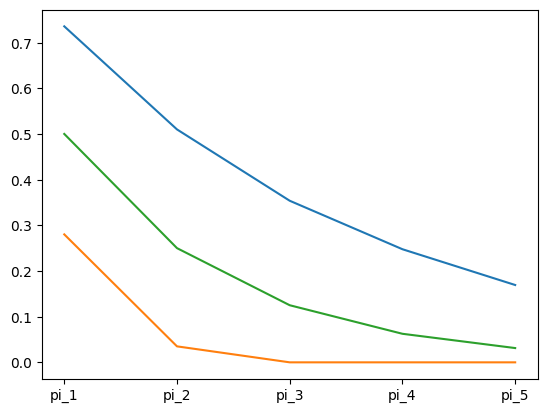

{'k0': [0.8855375096673493, 1.0431080361895781, 'optimal', 'optimal'], 'k1': 5, 'mu_1': [0.2921794970643173, 0.6513562268159923, 'optimal', 'optimal'], 'mu_2': [0.0364894753833948, 0.45151464714422435, 'optimal', 'optimal'], 'mu_3': [-1.8449585736378385e-13, 0.31324982368813, 'optimal', 'optimal'], 'mu_4': [-1.5448493810467664e-13, 0.2192630254619914, 'optimal', 'optimal'], 'mu_5': [-1.4237941229498513e-13, 0.14992238993665463, 'optimal', 'optimal']}


In [60]:
# solve LP using data
N = 6
M = N - 1
solutions_trial = bursty_LP(N, intervals_trial, k1=5)

# extract distribution bounds
labels = [f'mu_{m}' for m in range(1, M + 1)]
lower = [solutions_trial[var][0] / solutions_trial['k0'][1] for var in labels]
upper = [solutions_trial[var][1] / solutions_trial['k0'][0] for var in labels]
dist = [f'pi_{m}' for m in range(1, M + 1)]

# true distribution
true_dist = [0.5 * (1 - 0.5)**m for m in range(0, M)]

# plot
plt.plot(dist, upper, label = "Upper bound")
plt.plot(dist, lower, label = "Lower bound")
plt.plot(dist, true_dist, label = "True value")
plt.show()

# print bounds
print(solutions_trial)

See that the bounds produced for the raw distribution of $ \pi_m $'s are accurate, although not the most precise (slightly bigger than previous bounds as scaled by the [0.9, 1.1] bounds of $ k_0 $)

 This is good as it means we can still infer bounds on raw distributions when we have birth and death distributions and cannot fix both k parameters.

# Birth and Death Distributions

$ \varnothing \stackrel{k_{0}}\longrightarrow m X \text{ , m a R.V. taking values in \{1,2,...\} } $

$ n X \stackrel{k_{1}}\longrightarrow \varnothing \text{ , n a R.V. taking values in \{1,2,...\} } $

We can equivalently describe this as a process with reactions for each burst size:

$ \varnothing \stackrel{k_{0} \pi_{1}}\longrightarrow X \quad \varnothing \stackrel{k_{0} \pi_{2}}\longrightarrow 2X \quad \cdots \quad
\varnothing \stackrel{k_{0} \pi_{m}}\longrightarrow mX \quad \cdots \quad \text{ , where } \pi_{x} = P(m = x) $

$ X \stackrel{k_{1} \psi_{1}}\longrightarrow \varnothing \quad 2X \stackrel{k_{1} \psi_{2}}\longrightarrow \varnothing \quad \cdots \quad
    nX \stackrel{k_{1} \psi_{n}}\longrightarrow \varnothing \quad \cdots \quad \text{ , where } \psi_{x} = P(n = x) $


# Simulation

In [61]:
def choose(n, k):
    """Calculate nCk = n! / k!(n-k)!. Return 0 if k > n"""
    if k > n:
        return 0
    else:
        return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))

In [62]:
def discrete_sampler(p, s, normalise=False):
    """Sample from discrete distribution p, with values s, using inversion."""
    if normalise:
        p = np.array(p) / sum(p)
    cdf = np.cumsum(p)
    u = np.random.uniform(0,1)
    sample_ind = np.argmax(cdf > u)
    if s:
        return s[sample_ind]
    else:
        return sample_ind

In [63]:
def sample_path_bursty_birth_death(initial_state, params, tmax, plot=False):
    """
    Simulate a sample path of bursty gene expression with birth and death distributions

    Inputs:
    initial state: positive integer initial value of path
    params: [k0, k1, b, pi, psi] positive values of reaction rates and dist parameters
    tmax: length of sample path
    plot: whether to plot the sample path

    Outputs:
    path: list of visited states
    jump_times: list of state transition times
    """
    # parameters
    k0, k1, pi, psi = params['k0'], params['k1'], params['pi'], params['psi']

    # initialise time and state (also store jump times)
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate until stopping time
    while t < tmax:
        # simulate holding time of current state (x)
        x = path[-1]
        
        # holding rate: -q(x,x) = sum q(x,y) over y
        # for large x may need to explicitly add 0's to death dist
        # allowing summing over these reactions of reaction 0 
        if len(psi) < x:
            psi = psi + [0 for i in range(x - len(psi))]
        q_hold = k0 + k1 * sum([choose(x, n) * psi[n - 1] for n in range(1, x + 1)])
        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        # P(x -> y) = q_xy / q_hold

        # simulate death or birth:
        # P(birth) = k0 / q_hold
        # P(death) = 1 - P(birth)
        u = np.random.uniform(0,1)
        if u < (k0 / q_hold):
            # birth: sample from geometric dist, or given pi distribution
            if params['b']:
                m = np.random.geometric(params['b'])
                path.append(x + m)
            else:
                # sample from pi birth distribution for births sizes {1, ...}
                M = len(pi)
                birth_size = [m for m in range(1, M + 1)]
                m = discrete_sampler(pi, birth_size)
                path.append(x + m)
        # death: sample from psi distribution for death sizes {1, ... , x}
        else:
            dist = [psi[n - 1] * choose(x, n) for n in range(1,x + 1)]
            death_size = [n for n in range(1, x + 1)]
            n = discrete_sampler(dist, death_size, normalise=True)
            path.append(x - n)

    if plot:
        # plot path against jump times
        plt.plot(jump_times, path)
        plt.xlabel("Time")
        plt.ylabel("Number of molecules")

    return path, jump_times

### Check

For a birth and death distribution of $ \pi_1 = 1 $ and $ \psi_1 = 1 $ the model reduces to a simple birth death. We can check this against the birth model (with geom(1) birth dist) and a simple birth death.

In [64]:
def sample_path(x0, params, tmax, plot=False):
    """
    Simulate sample path of birth death reaction

    x0 = initial state
    params = [k0, k1]
    tmax = time of simulation

    return states visited and jump times
    """

    # parameters
    k1 = params[0]
    k2 = params[1]

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate until stopping time
    while t < tmax:

        # current state
        x = path[-1]

        # rates
        q_birth = k1
        q_death = k2 * x
        q_hold = q_birth + q_death

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        if u < q_birth / q_hold:
            path.append(x + 1)
        else:
            path.append(x - 1)

    if plot:
        plt.plot(jump_times, path)

    return path, jump_times

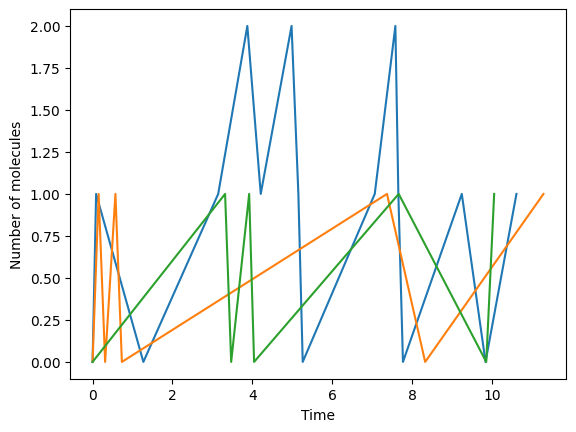

In [65]:
k0, k1 = 0.5, 1
b = 1
tmax = 10
params = {'k0': k0, 'k1': k1, 'b': None, 'pi': [1], 'psi': [1] }
for i in range(1):
    path, jumps = sample_path_bursty_birth_death(0, params, tmax, plot=True)
for i in range(1):
    path, jumps = sample_path_bursty(0, [k0, k1, b], tmax, plot=True)
for i in range(1):
    path, jumps = sample_path(0, [k0, k1], tmax, plot=True)

# Bootstrapping

Follow exactly the same method as when just using a birth distribution:
- simulate n sample paths and record states at $ t_{max} $
- Create N bootstrap samples, for each find state's proportions
- use quantiles to get interval estimates on stationary distribution vales

In [66]:
def bootstrap(x_list, initial_state, params, tmax, n, N, plot=False, printing=False):
    """
    Use sample paths and bootstrapping to find confidence intervals of
    stationary distribution values.

    Inputs:
    x_list: states to calculate stationary estimates for
    initial state: initial value of all sample paths
    params: dict of specified parameters [k0, k1, b, pi, psi]
    tmax: length of simulation
    n: number of sample paths
    N: number of bootstrap samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of states in x_list
    """

    # simulate n sample paths
    states = []
    for i in range(n):
        path, jumps = sample_path_bursty_birth_death(initial_state, params, tmax, plot=plot)
        states.append(path[-2]) # last state before tmax
    plt.show()

    # simulate N bootstrap samples: estimates p(x) for each, and for each x
    estimates = [[] for x in x_list]
    for i in range(N):
        sample = random.choices(states,k = n)
        for i, x in enumerate(x_list):
            estimates[i].append(sample.count(x) / n)

    # create confidence intervals (95%) via 2.5%, 97.5% quantiles for each x
    intervals = [np.quantile(est,[0.025,0.975]) for est in estimates]
    
    # plot histograms and CI
    for i, x in enumerate(x_list):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[i][0]}, {intervals[i][1]})")
        if plot:
            plt.hist(estimates[i])
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[i][0], color="red")
            plt.axvline(intervals[i][1], color="red")
            plt.show()

    # return CIs
    return intervals

### Test

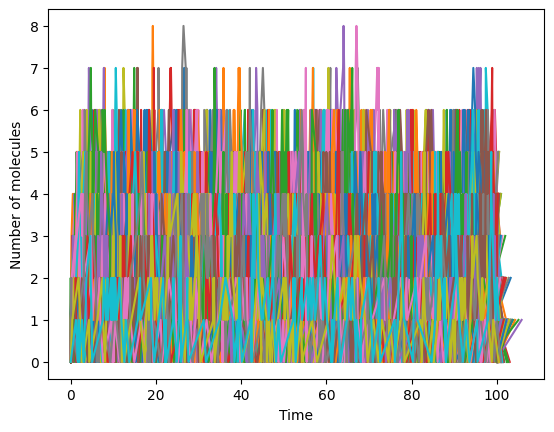

95% CI for p(0) is: (0.35, 0.41)


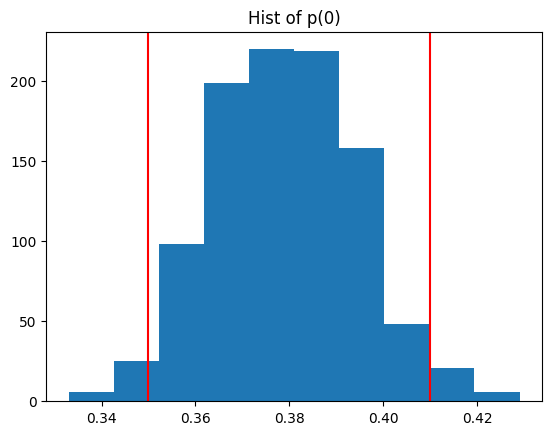

95% CI for p(1) is: (0.349975, 0.408)


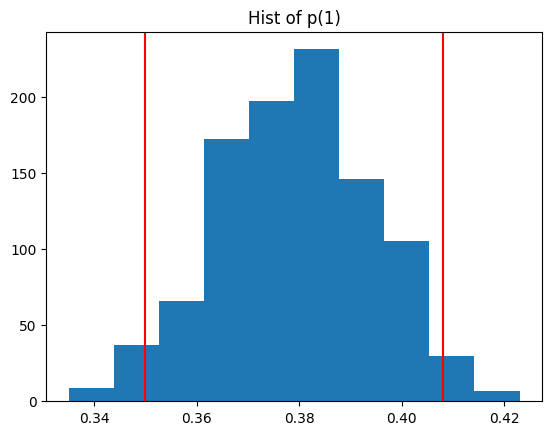

95% CI for p(2) is: (0.147, 0.194)


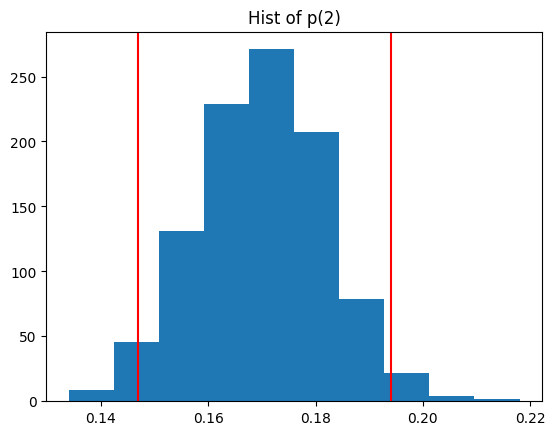

95% CI for p(3) is: (0.044, 0.073)


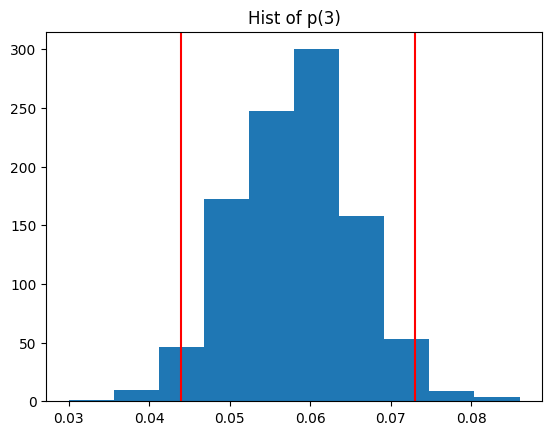

In [67]:
params = {'k0': 1, 'k1': 1, 'b': None, 'pi': [1], 'psi': [1]}
intervals = bootstrap([0, 1, 2, 3], 0, params, 100, 1000, 1000, plot=True, printing=True)

# Linear programming

Now need to formulate the LP to estimate the birth and death distributions, using the confidence intervals as bounds on the stionary distribution of the chain:

Given CI bounds on $ p(0) , \cdots , p(x_{max}) $ expect to be able to estimate $ \pi_1 , \cdots , \pi_{x_{max}-1} $ and $ \psi_1 , \cdots ,  \psi_{x_{max}-1} $. 

In [71]:
def bursty_birth_death_LP(K, M, x_max, intervals, k0=None, k1=None):
    """
    Solve bursty LP system to get interval bounds on parameters.

    Inputs:
    K: maximum death size to consider (>= 1)
    M: maximum birth size to consider (>= 1)
    x_max: largest bounded state used p = [p(0), ..., p(x_max)]
    intervals: confidence intervals for states

    Outputs:
    solutions: dict with keys variables, values their solution intervals

    Restrictions:
    K <= x_max
    M <= x_max - K
    intevals should contain AT LEAST p(0), ..., p(x_max) bounds
    """
    # Q_r matrices: (x_max - K + 1) x (x_max + 1) : (rows) x (columns)
    #   rows > columns: (x_max + 1) x (x_max + 1) diagonal, drop K rows
    #   or just overkill all diagonals and cut to size
    # Q0 = -I
    Q0 = (np.diag([-1 for x in range(x_max + 1)]))[:x_max - K + 1, :x_max + 1]
    # Q0m = I shifted down m rows
    def Q0m(m):
        """m = {1, 2, ...}."""
        return np.diag([1 for x in range(x_max + 1)], -m)[:x_max - K + 1, :x_max + 1]
    # Q1n = n above diagonal, main diagonal starting n down
    def Q1n(n):
        """n = {1, 2, ...}."""
        return (np.diag([0 if x < n else -choose(x,n) for x in range(x_max + 1)]) +
                np.diag([choose(x,n) for x in range(n, x_max + 1)], n))[:x_max - K + 1, :x_max + 1]

    # create bounds from CI's
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds: truncate as using p(0), ..., p(x_max)
    pl = np.array(pl)[:x_max + 1]
    pu = np.array(pu)[:x_max + 1]

    # Construct the problem

    # Variables:
    # specify k1 or k0 manually
    if not k0:
        k0 = cv.Variable(1)
    if not k1:
        k1 = cv.Variable(1)
    # birth and death distributions (multiplied by respective k's)
    lam = cv.Variable(K)
    mu = cv.Variable(M)
    # z's: p multiplied by respective k, same length as p
    z0 = cv.Variable(x_max + 1)
    z1 = cv.Variable(x_max + 1)
    # w, y's: p multiplied by lam's and mu's
    w = cv.Variable((x_max + 1, K))
    y = cv.Variable((x_max + 1, M))

    # constraints
    constraints = [
        # Qp = 0
        Q0 @ z0 == 0,
        sum([Q0m(m + 1) @ y[:, m] for m in range(0, M)]) +
        sum([Q1n(n + 1) @ w[:, n] for n in range(0, K)]) == 0,
        # non-negative
        k0 >= 0, k1 >= 0, mu >= 0, lam >= 0, z0 >= 0, z1 >= 0, y >= 0, w >=0,
        # p bounds: z's
        k0 * pl <= z0, z0 <= k0 * pu,
        k1 * pl <= z1, z1 <= k1 * pu,
        # distribution bounds
        sum([y[:, m] for m in range(0, M)]) <= z0,
        sum([w[:, n] for n in range(0, K)]) <= z1,
        sum([mu[m] for m in range(0, M)]) <= k0,
        sum([lam[n] for n in range(0, K)]) <= k1,
        # dist. const.
        sum([z0[x] for x in range(x_max + 1)]) <= k0,
        sum([z1[x] for x in range(x_max + 1)]) <= k1,
    ]
    # p bounds: y's and w's
    for m in range(0, M):
        constraints +=  [
            mu[m] * pl <= y[:, m], y[:, m] <= mu[m] * pu,
            # dist. const.
            sum([y[x, m] for x in range(x_max + 1)]) <= mu[m]
        ]
    for n in range(0, K):
        constraints += [
            lam[n] * pl <= w[:, n], w[:, n] <= lam[n] * pu,
            # dist. const.
            sum([w[x, n] for x in range(x_max + 1)]) <= lam[n]
        ]

    # solution interval dict
    solutions = {}

    # solver function
    def solver(dict_name, var, solutions):
        # create inteval
        solutions[dict_name] = []
        # min and max objectives
        objective_min = cv.Minimize(var)
        objective_max = cv.Maximize(var)
        # min and max problems
        prob_min = cv.Problem(objective_min, constraints)
        prob_max = cv.Problem(objective_max, constraints)   
        # solve min: add to solution
        result_min = prob_min.solve()
        try:
            solutions[dict_name].append(var.value.item())
        except:
            solutions[dict_name].append(None)
        # solve max: add to solution
        results_max = prob_max.solve()
        try:
            solutions[dict_name].append(var.value.item())
        except:
            solutions[dict_name].append(None)
        # add statuses
        solutions[dict_name].append(prob_min.status)
        solutions[dict_name].append(prob_max.status)

    # solve for k0
    if type(k0) == int:
        solutions['k0'] = k0
    else:
        solver('k0', k0, solutions)

    # solve for k1
    if type(k1) == int:
        solutions['k1'] = k1
    else:
        solver('k1', k1, solutions)

    # solve for mu_1, mu_2, ..., mu_M
    for m in range(0, M):
        solver(f'mu_{m + 1}', mu[m], solutions)

    # solve for lam_1, lam_2, ..., lam_K
    for n in range(0, K):
        solver(f'lam_{n + 1}', lam[n], solutions)

    return solutions

# Test

- Simulate data from reaction with $ \pi_1 = 1 , \phi_1 = 1 , k_0 = 1, k_1 = 1 $
- Bootstrap to estimate CI's for states {0, 1, ..., $x_{max}$} for a sufficient $ x_{max} $
- fix $ k_0 = 1 $, specify K = 1 and M = 1 in LP solver
- obtain raw distribution bounds: $ k_0 = 1 $ fixed, so $ \mu_1 = \pi_1 $, adjust $ \lambda_1 $ bounds dividing by $ k_1 $ bounds to get $ \psi_1 $ bounds 

In [69]:
params = {'k0': 1, 'k1': 1, 'b': None, 'pi': [1], 'psi': [1]}
x_max = 10
intervals = bootstrap([x for x in range(x_max + 1)], 0, params, 100, 5000, 5000, plot=False, printing=True)

95% CI for p(0) is: (0.3614, 0.3882)
95% CI for p(1) is: (0.3496, 0.376)
95% CI for p(2) is: (0.1692, 0.1908)
95% CI for p(3) is: (0.0564, 0.0698)
95% CI for p(4) is: (0.0118, 0.0186)
95% CI for p(5) is: (0.0022, 0.0056)
95% CI for p(6) is: (0.0, 0.0014)
95% CI for p(7) is: (0.0, 0.0)
95% CI for p(8) is: (0.0, 0.0)
95% CI for p(9) is: (0.0, 0.0)
95% CI for p(10) is: (0.0, 0.0)


In [73]:
solutions = bursty_birth_death_LP(K=1, M=1, x_max=5, intervals=intervals, k0=1, k1=1)
solutions

{'k0': 1,
 'k1': 1,
 'mu_1': [None, None, 'infeasible', 'infeasible'],
 'lam_1': [None, None, 'infeasible', 'infeasible']}

# Updated Code

Implement new optimized code for sampling and bootstrapping. This allows fast simulation of geometric or other burst distribtions.

In [5]:
def sample_path(x0, params, n, tmax, ts, plot=False):
    """
    Simulate a single sample path of birth death reaction
    Sample values at intervals ts after a burn-in time of tmax to give n values

    x0 = initial state
    params = dictionary of k0, k1, geometric parameter b or discrete distribution
    n = total number of samples
    tmax = burn-in simulation time
    ts = time between successive samples

    return states visited and jump times
    """

    # reaction parameters
    k0 = params["k0"]
    k1 = params["k1"]
    try:
        # geometric bursts
        b = params["b"]
        geom = True
    except KeyError:
        # discrete distribution of bursts
        pi = params["pi"]
        geom = False

    # initialise time and state (also store jump times)
    t = 0
    path = [x0]
    jump_times = [0]

    # simulate for: burn-in time + (n-1) times between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x = path[-1]

        # rates
        q_deg = k1 * x
        q_hold = k1 * x + k0

        # exponential holding time of state
        t_hold = -math.log(random.random()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        u = random.random()
        # degradation
        if u < q_deg / q_hold:
            path.append(x - 1)
        # bursting
        else:
            # sample m from geom(b) OR pi distribution
            if geom:
                m = np.random.geometric(b)
            else:
                # pi[i] = P(state i + 1)
                m = np.random.choice(range(1, len(pi) + 1), p=pi)
            path.append(x + m)

    # create step function of sample path from jump times and jump values
    path_function = scipy.interpolate.interp1d(jump_times, path, kind='previous')
    
    # take values at sampling times as samples
    sample_times = [tmax + i * ts for i in range(n)]
    samples = path_function(sample_times)
    samples = np.array([int(x) for x in samples])

    # plot sample path with burn-in and sampled values
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, path_function(x), label="Sample path")
        plt.axvline(tmax, label="Burn-in time: t_max", color="orange")
        plt.scatter(sample_times, path_function(sample_times), color="red", label="Samples")
        plt.legend()
        plt.show()

    return samples

In [6]:
def bootstrap_optim(x0, params, n, N, tmax=100, ts=10, plot=False, printing=False):
    """
    Simulate reaction and bootstrap to find confidence intervals of stationary
    distribution values.

    Inputs:
    x0: initial state
    n: number of samples
    N: number of bootstrap samples
    tmax: burn-in time
    ts: time between samples
    plot: whether to plot histograms of bootstrap estimates with CI lines
    printing: whether to print CI's

    Output:
    intervals: list of confidence intervals for stationary distribution values
        of all states up to largest observed
    """
    # simulate
    samples = sample_path(x0, params, n, tmax, ts, plot=plot)

    # find the largest state
    x_max = np.max(samples)

    # N boostrap samples as N x n array
    bootstrap = np.random.choice(samples, size=(N, n))
    # produce N x (x_max + 1) array of counts of states:
    # offset each row by multiple of x_max + 1 for efficient bincount
    bootstrap_offs = bootstrap + np.arange(N)[:,None]*(x_max + 1)
    counts = np.bincount(bootstrap_offs.ravel(), minlength=N*(x_max + 1)).reshape(-1,x_max + 1)
    # dividing by n gives columns of estimates
    # take 2.5%, 97.5% percentiles of each column (i.e each p(x))
    quantiles = np.quantile(counts / n, [0.025, 0.975], axis=0)
    # form intervals: list of [2.5%, 97.5%] values for each p(x)
    intervals = [quantiles[:,i] for i in range(x_max + 1)]

    # plot histograms and CI
    for x in range(x_max + 1):
        if printing:
            print(f"95% CI for p({x}) is: ({intervals[x][0]}, {intervals[x][1]})")
        if plot:
            plt.hist(counts[:, x] / n)
            plt.title(f"Hist of p({x})")
            plt.axvline(intervals[x][0], color="red")
            plt.axvline(intervals[x][1], color="red")
            plt.show()

    # return CIs
    return intervals

# Non-Linear Programming

In [7]:
import gurobipy as gp
from gurobipy import GRB
import scipy
import time

In [8]:
def bursty_NLP(N, intervals, k0=None, k1=None, K=100, printing=True):
    """
    Solve bursty NLP system to get bounds on parameters

    Inputs:
    N: number of rows of Q / number of equations used
    intervals: CI's on at least N + 1 states
    k0: (optional) value of k0
    k1: (optional) value of k1
    K: prescribed max on kr variables in optimization (for computation)
    printing: whether to print solution information
    """
    # largest burst 1 less than N
    M = N - 1

    # create Qr matrices: N rows requires N + 1 columns to include all terms (so (N, N + 1) size)
    # Q1: degradation
    Q1 = (np.diag([-x for x in range(0,N+1)],0) + np.diag([x for x in range(1,N+1)],1))[:-1, :]
    # Q00, Q01, ... : bursting
    Q00 = np.diag([-1 for x in range(0, N + 1)])[:-1, :]
    def Q0(m):
        """m = {1, 2, ...}"""
        return np.diag([1 for x in range(0, N + 1 - m)], -m)[:-1, :]

    # bounds from CI
    pl = [intr[0] for intr in intervals]
    pu = [intr[1] for intr in intervals]

    # define bounds: truncate to N + 1 values as using up to Nth equation
    pl = np.array(pl)[:N + 1]
    pu = np.array(pu)[:N + 1]
    
    # create model
    model = gp.Model("burst")

    # set options
    if not printing:
        model.Params.LogToConsole = 0

    # add variable p in [0, 1]
    p = model.addMVar(shape=N + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
    pis = model.addMVar(shape=M, vtype=GRB.CONTINUOUS, name="pis", lb=0, ub=1)

    # initialize fixed / variable rates, constrain to [0, K] for computational reasons
    if not k0:
        k0 = model.addVar(vtype=GRB.CONTINUOUS, name="k0", lb=0, ub=K)
        k0_var = True
    else:
        k0_var = False
    if not k1:
        k1 = model.addVar(vtype=GRB.CONTINUOUS, name="k1", lb=0, ub=K)
        k1_var = True
    else:
        k0_var = False

    # Constraints:
    # Stationary condition: Qp = 0
    model.addConstr(k1*(Q1 @ p) + k0*(Q00 @ p) + gp.quicksum([k0*pis[m]*(Q0(m + 1) @ p) for m in range(0, M)]) == 0, name="Qp=0")
    # bounds
    model.addConstr(pl <= p, name="lb")
    model.addConstr(p <= pu, name="ub")
    # distributions
    model.addConstr(p.sum() <= 1, name="pdist")
    model.addConstr(pis.sum() <= 1, name="pidist")

    # solution dictionary
    solutions = {}

    # optimize for each variable in turn
    if k0_var:
        # minimize
        model.setObjective(k0, GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(k0, GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions['k0'] = [min_val, max_val]
    else:
        solutions['k0'] = [k0]
    
    if k1_var:
        # minimize
        model.setObjective(k1, GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(k0, GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions['k1'] = [min_val, max_val]
    else:
        solutions['k1'] = [k1]

    for m in range(0, M):
        # minimize
        model.setObjective(pis[m], GRB.MINIMIZE)
        try:
            model.optimize()
            min_val = model.ObjVal
        except:
            min_val = None

        # maximize
        model.setObjective(pis[m], GRB.MAXIMIZE)
        try:
            model.optimize()
            max_val = model.ObjVal
        except:
            max_val = None
        
        # store
        solutions[f'mu_{m + 1}'] = [min_val, max_val]

    return solutions

## Test

In [83]:
def plot_solution(N, intervals, params, show=True, colour_1="blue", colour_2="orange", truth=True, label_1="NLP bounds", label_2="LP bounds"):
    '''
    Plot the solution bounds against true burst distribution

    N: number of equations used
    intervals: CI bounds (must have at least N + 1 intervals)
    params: dict of k0, k1, geometric parameter or burst distribution

    NOTE: implicit assumption that k0 = 1 so that mu = k0pi = pi so LP and NLP
        both estimate the same quantities
    '''
    # pi's estimated
    M = N - 1

    # solve using NLP
    s = time.time()
    solution_NLP = bursty_NLP(N, intervals, k0=params['k0'], printing=False)
    time_NLP = time.time() - s

    # solve using LP
    s = time.time()
    solution_LP = bursty_LP(N, intervals, k0=params['k0'])
    time_LP = time.time() - s

    # extract distribution bounds
    labels = [f'mu_{m}' for m in range(1, M + 1)]
    lower_NLP = [solution_NLP[var][0] for var in labels]
    upper_NLP = [solution_NLP[var][1] for var in labels]
    lower_LP = [solution_LP[var][0] for var in labels]
    upper_LP = [solution_LP[var][1] for var in labels]

    # true burst distribution
    try:
        # geometric(b)
        true_dist = [params['b'] * (1 - params['b'])**m for m in range(0, M)]
    except KeyError:
        # specified pi's
        true_dist = [params['pi'][m] for m in range(0, M)]

    # time
    print(f"LP: {time_LP} \nNLP: {time_NLP}")

    # plot
    s = 20
    alpha = 0.7
    plot_labels = [f'{m}' for m in range(1, M + 1)]
    plt.title("Solution bounds on burst distribution")
    plt.xlabel("Burst size")
    plt.ylabel("Probability")
    # NLP
    plt.plot(plot_labels, upper_NLP, color=colour_1, label=label_1, alpha=alpha)
    plt.plot(plot_labels, lower_NLP, color=colour_1, alpha=alpha)
    plt.scatter(plot_labels, upper_NLP, color=colour_1, s=s)
    plt.scatter(plot_labels, lower_NLP, color=colour_1, s=s)
    # LP
    plt.plot(plot_labels, upper_LP, color=colour_2, label=label_2, alpha=alpha)
    plt.plot(plot_labels, lower_LP, color=colour_2, alpha=alpha)
    plt.scatter(plot_labels, upper_LP, color=colour_2, s=s)
    plt.scatter(plot_labels, lower_LP, color=colour_2, s=s)
    # Truth
    if truth:
        plt.plot(plot_labels, true_dist, color="red", label="True dist.", alpha=alpha)
        plt.scatter(plot_labels, true_dist, color="red", s=s)
    plt.legend()
    if show:
        plt.show()

    return solution_LP, solution_NLP

In [82]:
# parameters
params_1 = {'k0': 1, 'k1': 1, 'b': 0.9}
params_2 = {'k0': 1, 'k1': 1, 'b': 0.5}
params_3 = {'k0': 1, 'k1': 1, 'b': 0.1}

# sample and bootstrap
print(f"Intervals: \n")
intervals_1 = bootstrap_optim(x0=0, params=params_1, n=1000, N=1000, tmax=100, ts=10, plot=False, printing=True)
print(f"\nIntervals: \n")
intervals_2 = bootstrap_optim(x0=0, params=params_2, n=500, N=500, tmax=100, ts=10, plot=False, printing=True)
intervals_2_large = bootstrap_optim(x0=0, params=params_2, n=5000, N=5000, tmax=100, ts=10, plot=False, printing=True)
print(f"\nIntervals: \n")
intervals_3 = bootstrap_optim(x0=0, params=params_3, n=1000, N=1000, tmax=100, ts=10, plot=False, printing=True)

Intervals: 

95% CI for p(0) is: (0.303975, 0.361025)
95% CI for p(1) is: (0.302975, 0.364)
95% CI for p(2) is: (0.196, 0.24602499999999997)
95% CI for p(3) is: (0.064975, 0.098)
95% CI for p(4) is: (0.01, 0.027)
95% CI for p(5) is: (0.006, 0.019)
95% CI for p(6) is: (0.0, 0.0)
95% CI for p(7) is: (0.0, 0.003)
95% CI for p(8) is: (0.0, 0.003)

Intervals: 

95% CI for p(0) is: (0.212, 0.29)
95% CI for p(1) is: (0.222, 0.296)
95% CI for p(2) is: (0.146, 0.212)
95% CI for p(3) is: (0.108, 0.168)
95% CI for p(4) is: (0.044, 0.088)
95% CI for p(5) is: (0.02695, 0.066)
95% CI for p(6) is: (0.018, 0.051049999999999957)
95% CI for p(7) is: (0.004950000000000003, 0.026)
95% CI for p(8) is: (0.002, 0.017049999999999954)
95% CI for p(9) is: (0.0, 0.014)
95% CI for p(10) is: (0.0, 0.006)
95% CI for p(11) is: (0.0, 0.0)
95% CI for p(12) is: (0.0, 0.006)
95% CI for p(13) is: (0.0, 0.0)
95% CI for p(14) is: (0.0, 0.0)
95% CI for p(15) is: (0.0, 0.008)
95% CI for p(0) is: (0.2344, 0.2582049999999999)


c:\Users\willi\Documents\Year 4 Project Work\Proj_venv\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


LP: 0.38080286979675293 
NLP: 0.3236277103424072


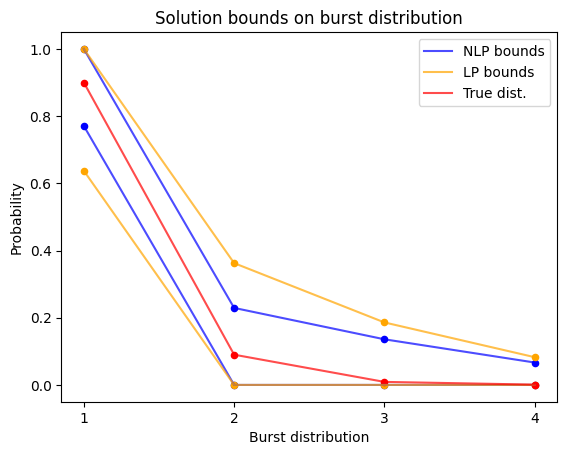

In [79]:
LP_solution_1, NLP_solution_1 = plot_solution(5, intervals_1, params_1)

LP: 1.0044739246368408 
NLP: 2.0244462490081787
LP: 1.0672838687896729 
NLP: 2.136791229248047


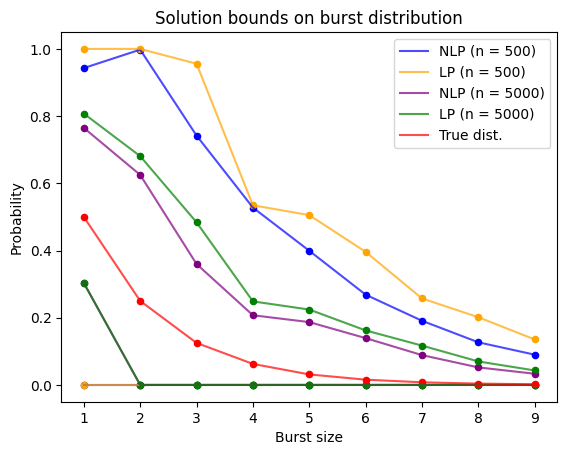

In [88]:
LP_solution_2, NLP_solution_2 = plot_solution(10, intervals_2, params_2, show=False, truth=False, label_1="NLP (n = 500)", label_2="LP (n = 500)")
LP_solution_2_large, NLP_solution_2_large = plot_solution(10, intervals_2_large, params_2, colour_1="purple", colour_2="green",
    label_1="NLP (n = 5000)", label_2="LP (n = 5000)")

LP: 1.2185430526733398 
NLP: 1.4399936199188232


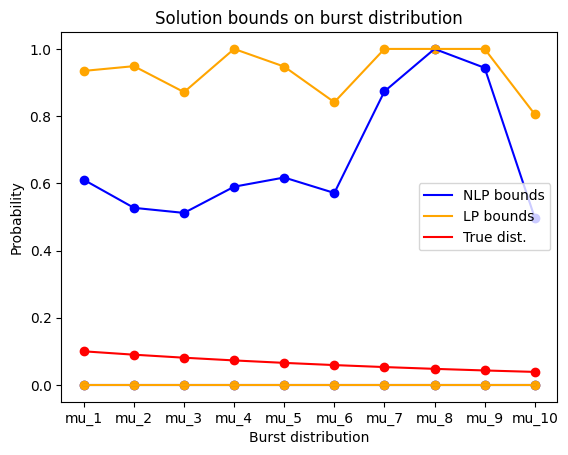

In [17]:
LP_solution_3, NLP_solution_3 = plot_solution(11, intervals_3, params_3)

### Geometric bursts

Testing for a range of geometric distributions we see that the NLP upper bounds are a strict improvement over the LP bounds, but that in general the lower bounds are the same (this is a common trend where the lower bounds are a 'harder' problem, often being trivially 0 as seen above).

We see that for small b, when the burst distribution Geom(b) is concentrated on a few states, the bounds produced are tight for both LP and NLP (but for only a few values, as we only have information on the few states). For larger b e.g. 0.5 the bounds loosen, until for very large values e.g. 0.9, where the distribution is spread over a lot of states, the bounds become poor. In the last example it would be easy to mis-interpret the resulting bounds as an indication of a bi-modal or poisson shaped bursting distribution rather than a shallow geometric, so we should be careful when interpreting results.

Intervals: 

95% CI for p(0) is: (0.069, 0.105)
95% CI for p(1) is: (0.094, 0.133)
95% CI for p(2) is: (0.094, 0.134)
95% CI for p(3) is: (0.081, 0.118)
95% CI for p(4) is: (0.073, 0.109)
95% CI for p(5) is: (0.063, 0.09602499999999999)
95% CI for p(6) is: (0.066, 0.09902499999999999)
95% CI for p(7) is: (0.047, 0.078)
95% CI for p(8) is: (0.048, 0.078)
95% CI for p(9) is: (0.029, 0.05502499999999998)
95% CI for p(10) is: (0.015, 0.034)
95% CI for p(11) is: (0.02, 0.041)
95% CI for p(12) is: (0.014, 0.033)
95% CI for p(13) is: (0.014975, 0.033)
95% CI for p(14) is: (0.009, 0.024)
95% CI for p(15) is: (0.005, 0.017)
95% CI for p(16) is: (0.005, 0.018)
95% CI for p(17) is: (0.001, 0.01)
95% CI for p(18) is: (0.002, 0.011)
95% CI for p(19) is: (0.003, 0.014)
95% CI for p(20) is: (0.001, 0.01)
95% CI for p(21) is: (0.0, 0.005)
95% CI for p(22) is: (0.0, 0.005)
95% CI for p(23) is: (0.0, 0.005)
95% CI for p(24) is: (0.0, 0.003)


95% CI for p(0) is: (0.0944, 0.1112)
95% CI for p(1) is: (0.1

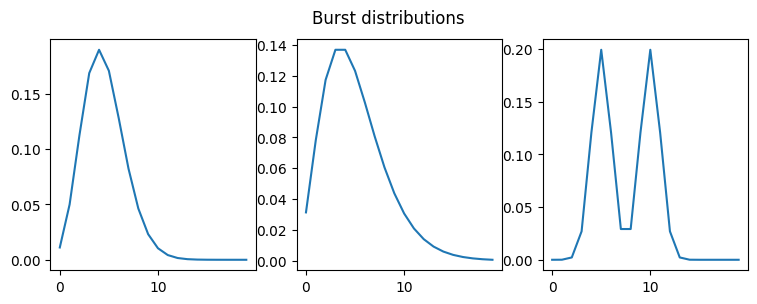

In [100]:
# parameters
burst_dist_4 = np.array([scipy.stats.poisson.pmf(x, mu = 4.5) for x in range(20)])
burst_dist_4 = burst_dist_4 / sum(burst_dist_4)
params_4 = {'k0': 1, 'k1': 1, 'pi': burst_dist_4}
burst_dist_5 = np.array([scipy.stats.nbinom.pmf(x, 5, 0.5) for x in range(20)])
burst_dist_5 = burst_dist_5 / sum(burst_dist_5)
params_5 = {'k0': 1, 'k1': 1, 'pi': burst_dist_5}
burst_dist_6 = np.array([scipy.stats.norm.pdf(x, loc = 5) for x in range(20)]) + np.array([scipy.stats.norm.pdf(x, loc = 10) for x in range(20)])
burst_dist_6 = burst_dist_6 / sum(burst_dist_6)
params_6 = {'k0': 1, 'k1': 1, 'pi': burst_dist_6}

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
plt.suptitle("Burst distributions")
axs[0].plot(burst_dist_4)
axs[1].plot(burst_dist_5)
axs[2].plot(burst_dist_6)

# sample and bootstrap
print(f"Intervals: \n")
intervals_4 = bootstrap_optim(x0=0, params=params_4, n=1000, N=1000, tmax=100, ts=10, plot=False, printing=True)
print("\n")
intervals_4_large = bootstrap_optim(x0=0, params=params_4, n=5000, N=5000, tmax=100, ts=10, plot=False, printing=True)
print(f"\nIntervals: \n")
intervals_5 = bootstrap_optim(x0=0, params=params_5, n=1000, N=1000, tmax=100, ts=10, plot=False, printing=True)
print(f"\nIntervals: \n")
intervals_6 = bootstrap_optim(x0=0, params=params_6, n=1000, N=1000, tmax=100, ts=10, plot=False, printing=True)

LP: 1.3458495140075684 
NLP: 2.3021724224090576
LP: 1.3163409233093262 
NLP: 2.5004184246063232


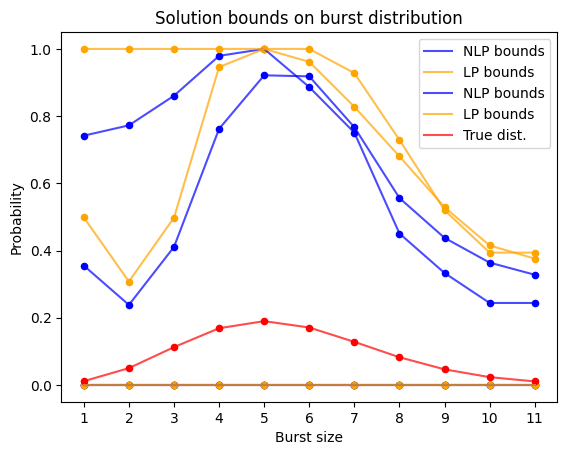

In [101]:
LP_solution_4, NLP_solution_4 = plot_solution(12, intervals_4, params_4, show=False, truth=False)
LP_solution_4_large, NLP_solution_4_large = plot_solution(12, intervals_4_large, params_4)

LP: 2.0484225749969482 
NLP: 3.6039135456085205


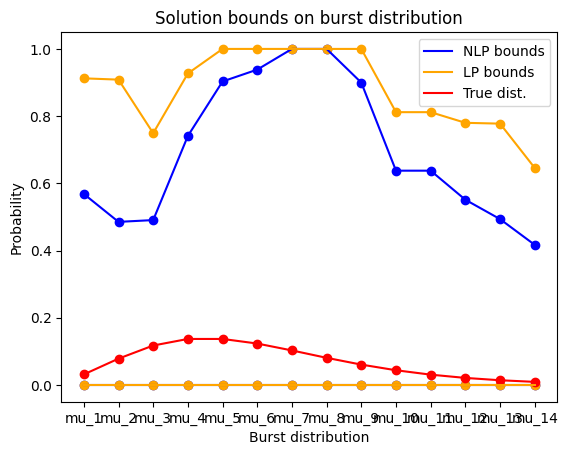

In [22]:
LP_solution_5,NLP_solution_5 = plot_solution(15, intervals_5, params_5)

LP: 4.167612552642822 
NLP: 7.326514482498169


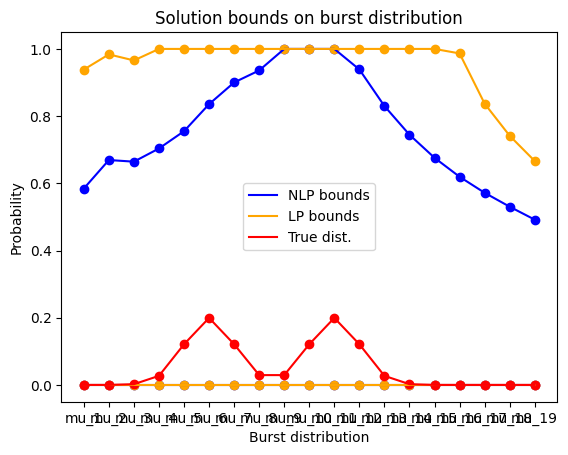

In [26]:
LP_solution_6, NLP_solution_6 = plot_solution(20, intervals_6, params_6)

### Non-geometric bursts

While there is evidence that that genes generally have geometric bursting behaviour, analysis of real data has shown that many samples suggest non-geometric bursts, so it is important to test how well methods can identify these. Note we saw above that a shallow geometric could easily be identified as a bi-modal / other distribution, so it is important to be careful when interpreting results.

Taking a poisson and negative binomial distribution centered away from 0, we see that both the LP and NLP can estimate the shape of the distribution (at least for the upper bound, the lower bound is trivial as is common), but that the tighter bounds produced by the NLP help to better identify the mode / shape of the distribution.

Taking a bi-modal distribution (here a mixture of 2 gaussians, discretized), we see that neither LP or NLP is able to identify 2 peaks, but the NLP produces significantly tighter bounds than the LP, making it a lot easier to identify the bursting behaviour.

See below that with a bi-modal distribution with modes further apart and larger sample size we are able to identify the 2 peaks.

Intervals: 

95% CI for p(0) is: (0.067, 0.102)
95% CI for p(1) is: (0.061975, 0.095)
95% CI for p(2) is: (0.056, 0.088)
95% CI for p(3) is: (0.055, 0.086)
95% CI for p(4) is: (0.042975, 0.07)
95% CI for p(5) is: (0.057, 0.088)
95% CI for p(6) is: (0.047, 0.078)
95% CI for p(7) is: (0.031975, 0.057)
95% CI for p(8) is: (0.033, 0.059)
95% CI for p(9) is: (0.03, 0.054024999999999976)
95% CI for p(10) is: (0.028, 0.052)
95% CI for p(11) is: (0.04, 0.066)
95% CI for p(12) is: (0.025, 0.047)
95% CI for p(13) is: (0.027, 0.05)
95% CI for p(14) is: (0.014, 0.031)
95% CI for p(15) is: (0.018, 0.038)
95% CI for p(16) is: (0.021, 0.042)
95% CI for p(17) is: (0.010975, 0.027)
95% CI for p(18) is: (0.011, 0.028)
95% CI for p(19) is: (0.006, 0.019)
95% CI for p(20) is: (0.004, 0.017)
95% CI for p(21) is: (0.002, 0.011)
95% CI for p(22) is: (0.003, 0.012)
95% CI for p(23) is: (0.002, 0.011)
95% CI for p(24) is: (0.004, 0.017)
95% CI for p(25) is: (0.001, 0.01)
95% CI for p(26) is: (0.0, 0.007)
95% C

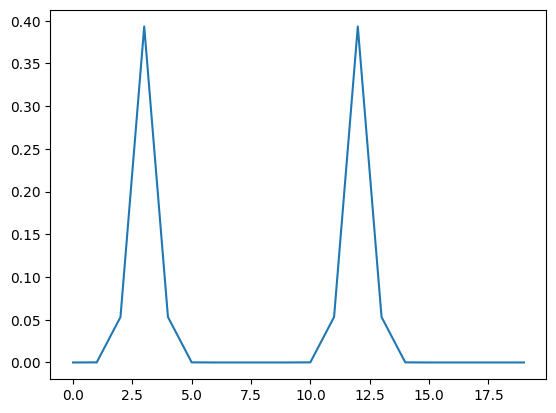

In [109]:
burst_dist_7 = np.array([scipy.stats.norm.pdf(x, loc = 3, scale=0.5) for x in range(20)]) + \
    np.array([scipy.stats.norm.pdf(x, loc = 12, scale=0.5) for x in range(20)])
burst_dist_7 = burst_dist_7 / sum(burst_dist_7)
params_7 = {'k0': 1, 'k1': 1, 'pi': burst_dist_7}

plt.plot(burst_dist_7)

# sample and bootstrap
print(f"Intervals: \n")
intervals_7 = bootstrap_optim(x0=0, params=params_7, n=1000, N=1000, tmax=100, ts=10, plot=False, printing=True)
print("\n")
intervals_7_large = bootstrap_optim(x0=0, params=params_7, n=5000, N=5000, tmax=100, ts=10, plot=False, printing=True)

LP: 4.8819661140441895 
NLP: 14.186477422714233


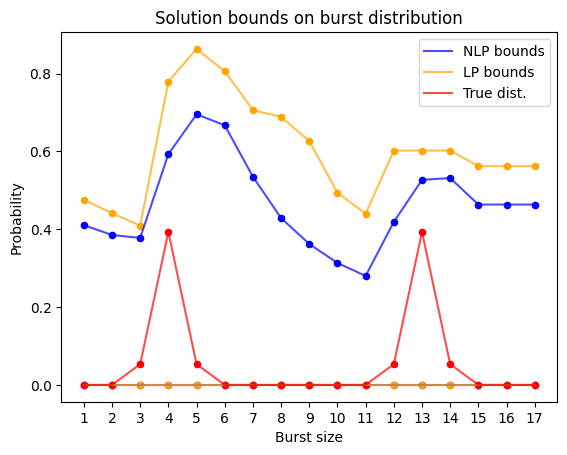

In [110]:
#LP_solution_7, NLP_solution_7 = plot_solution(20, intervals_7, params_7, show=False, truth=False)
LP_solution_7_large, NLP_solution_7_large = plot_solution(18, intervals_7_large, params_7)

LP: 4.839815855026245 
NLP: 80.03864479064941


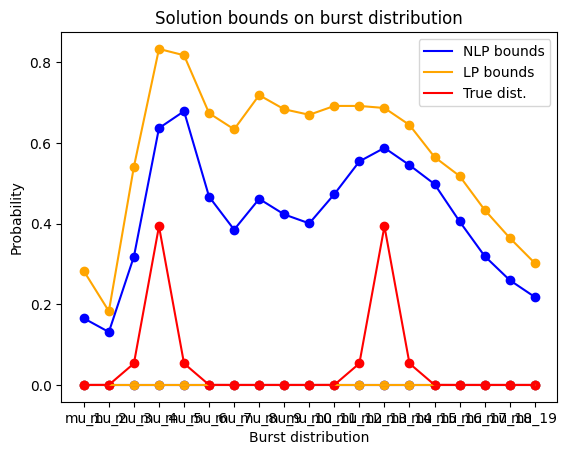

In [30]:
LP_solution_7, NLP_solution_7 = plot_solution(20, intervals_7, params_7)